In [1]:
# Import required libraries and functions
from acquire import get_telco_data
from prepare import train_validate_test_split, prep_telco
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import model

import warnings
warnings.filterwarnings("ignore")

# Acquire and Prepare Telco Churn Data

To acquire the Telco churn data I used the telco_churn database in our mySQL server and selected all columns from the customers, contract types, payment types, and internet service types

In [2]:
# Acquire data from sql database telco_churn
df = get_telco_data()

Using cached data


## Prepare Steps:
- Drop null/blank values. From prior exploration of dataset a small number of the total_charges are just whitespace - these are all new customers who haven't been with the company for >1 month. Given that it is a very small proportion of the total dataset (< 0.5%) these rows will be deleted for ease of computation later on
- Convert total_charges to float data type for later analysis as a continuous variable
- Encode categorical variables and rename:
        - senior citizen
        - sex
        - has phone
        - has internet service
        - has partner
        - has dependent
        - has paperless billing
        - is month to month contract type
        - on autopay
        - has streaming service
- Remove unnecessary columns after encoding

In [3]:
df = prep_telco(df)
train, validate, test = train_validate_test_split(df, target = 'churn', seed =123)

- The data is now split into 3 samples so that we can use the train sample to explore, fit the models, and evaluate without looking at new data
- The validate set is used to verify the models built are not overfit to the train dataset
- The test set will give an indicatio of how the model performs on unseen future data

# Exploratory Analysis: Who is most likely to churn?

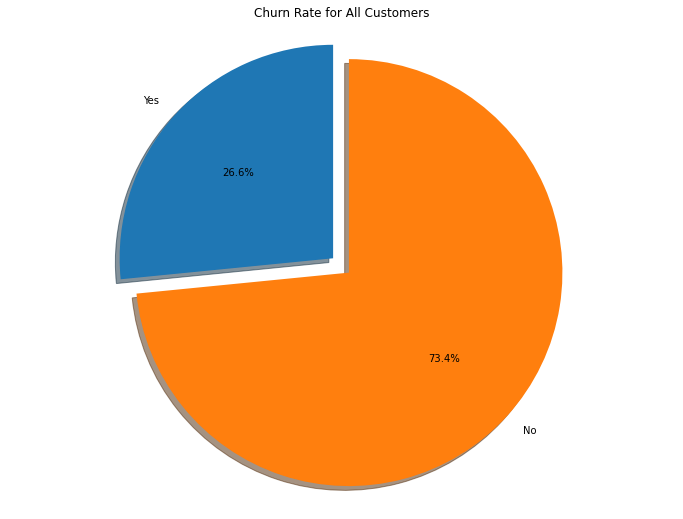

In [4]:
# Baseline churn: create DataFrame of churn values
churn_df = pd.DataFrame({'Yes':train.churn.sum(),'No':(train.churn == 0).sum()}, index = ['Churn']).T
labels = churn_df.index
sizes = churn_df.Churn
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(12,9))
# Create pie chart of churn vs no churn
p = ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
p = ax1.axis('equal')
p = plt.title('Churn Rate for All Customers')

In [5]:
# Set the baseline churn to a variable
baseline_churn = (train.churn == 1).mean()

## Our churn rate for all customers is 26.6%

## Question 1: Do any groups churn at rates significantly above or below the overall average?

### Groups defined as:
    - senior citizen
    - male vs female
    - partner vs no partner
    - dependent vs no dependent
    - Auto vs manual payers
    - Paperless billing vs not
    - Month to month vs long term
    - Internet service or not
    - Phone service or not
### Will perform chi squared tests to establish whether the churn rate is independent of whether someone is a member of that group or not

In [6]:
# Set alpha level for significance
alpha = 0.05

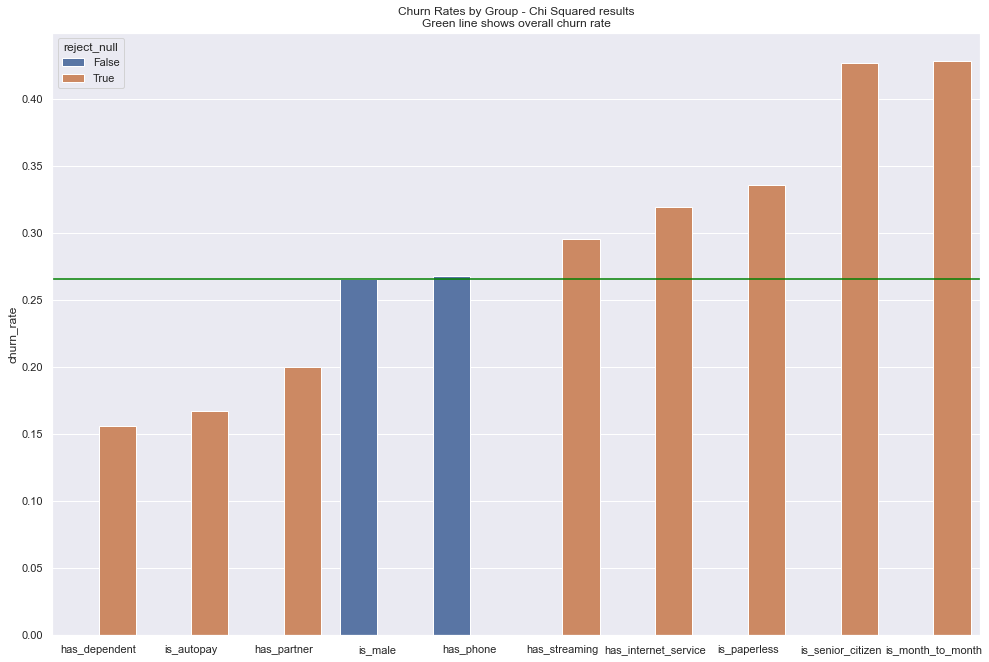

In [7]:
# Establish a list of the groups to be tested
groups = ['is_male', 'is_senior_citizen', 'has_partner', 'has_dependent', 'is_paperless','is_autopay','is_month_to_month','has_phone','has_internet_service','has_streaming']
reject_null = []
churn_rate=[]
# Iterate through groups and perform chi square test for each. Save churn rate and test result to lists
for group in groups:
    observed = pd.crosstab(train.churn, train[group])
    chi2, p, dof, expected = stats.chi2_contingency(observed)
    churn_rate.append((train.churn[train[group] == 1]).mean())
    reject_null.append(p<alpha)
    
# Create pandas DataFrame for plotting
results = pd.DataFrame(data = {'churn_rate':churn_rate,'reject_null':reject_null},index = groups)
results = results.sort_values(by= 'churn_rate')

# Plot bar plot of results, highlighting which groups we can reject the null hypothesis - ie there is a relationshio
sns.set(rc={'figure.figsize':(14,9)})
sns.barplot(data = results, x = results.index ,y = 'churn_rate', hue = 'reject_null',)
plt.tight_layout()
plt.title('Churn Rates by Group - Chi Squared results\nGreen line shows overall churn rate')
plt.axhline(y=baseline_churn, color = 'green')


## Four groups churn at rates significantly higher than the overall mean:
    - Senior citizens: 43%
    - Month to Month: 43%
    - Paperless billing: 34%
    - Those with internet service: 32%

## Three groups churn at rates significantly below the overall mean:
    - With dependents: 16%
    - Autopayers: 17%
    - With partners: 20%

## Question 2: Do the churners on the month to month plan pay higher per month on average than those who don't churn on month to month?
### Will perform a 2 sample t-test to check

In [8]:
# Create the independent samples
month_to_month = train[train.is_month_to_month==1]
churn_sample = month_to_month[month_to_month.churn == 1].monthly_charges
non_churn_sample = month_to_month[month_to_month.churn == 0].monthly_charges
# Perform the t-test
t, p = stats.ttest_ind(churn_sample, non_churn_sample, equal_var=False)
print(f"t: {t}, p/2 < alpha: {p/2<alpha}")

t: 11.098473710039949, p/2 < alpha: True


Text(0, 0.5, 'Average monthly charge ($)')

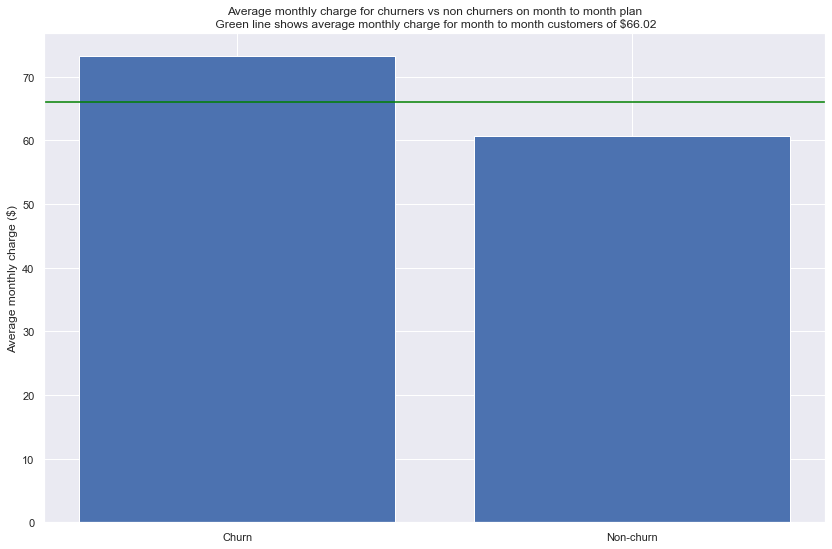

In [9]:
plt.bar(x=['Churn','Non-churn'], height =[churn_sample.mean(),non_churn_sample.mean()])
plt.title(f'Average monthly charge for churners vs non churners on month to month plan\n Green line shows average monthly charge for month to month customers of ${month_to_month.monthly_charges.mean():.2f}')
plt.axhline(month_to_month.monthly_charges.mean(), color = 'green')
plt.ylabel('Average monthly charge ($)')

### We reject the null hypothesis:
- Those who churn on the month to month plan do in fact pay more than those who do not churn
- Cost may be a factor causing them to churn

## Question 3: Of the groups that churn at higher than overall average, do any particular sub groups churn higher? 
    - Will focus on internet customers group: Fiber vs DSL
### Will perform a chi square test to check

[Text(0.5, 0, 'DSL'), Text(1.5, 0, 'Fiber optic')]

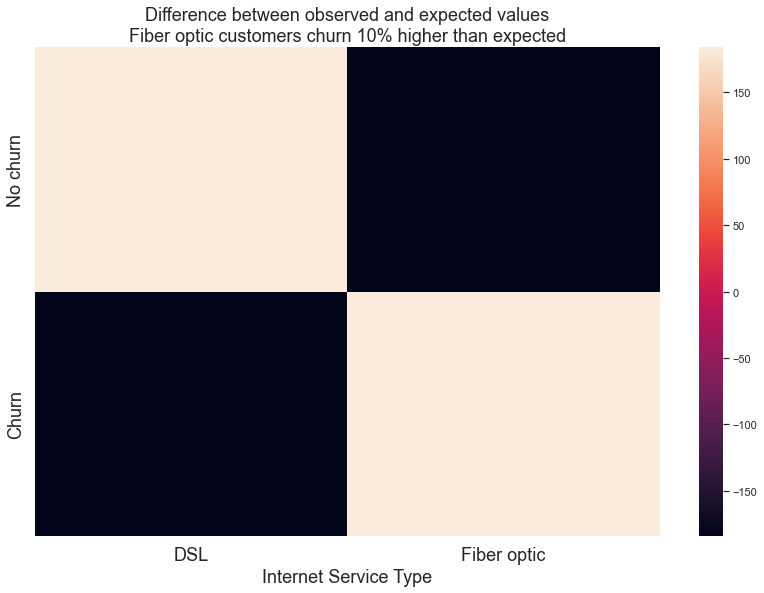

In [10]:
# create a dataframe of just internet customers from train
internet = train[train.has_internet_service == 1]
# create the observed dataframe of churn vs service type
observed = pd.crosstab(internet.churn, internet.internet_service_type)
chi2, p, dof, expected = stats.chi2_contingency(observed)
# create heatmap showing observed vs expected
observed.index.name=""
expected_df = pd.DataFrame(expected,index=[0,1], columns=['DSL','Fiber optic'])
observed - expected_df
ax = sns.heatmap(data = observed-expected_df, yticklabels=['No churn','Churn'])
ax.set_title('Difference between observed and expected values\nFiber optic customers churn 10% higher than expected', fontsize = 18)
ax.set_xlabel('Internet Service Type', fontsize = 18)
ax.set_yticklabels(['No churn','Churn'],fontsize = 18)
ax.set_xticklabels(['DSL','Fiber optic'],fontsize = 18)

## Churn and the type of internet service are not independent
- Fiber optic customers churn at a rate 10% higher than we'd expect. This is >180 additional customers churned.
- Customers seem to be more dissatisfied with our fiber internet service than our DSL

## Question 4: Within fiber customers - is there a particular option that is resulting in greater or less churn?

#### Looking at the internet service group, there are several options:
    - Streaming TV
    - Streaming movies
    - Tech support
    - Online security
    - Device protection
    - Online backup
### Is whether a fiber customer churns independent of whether he or she has a streaming service? TV, Movies, or both.
### Chi squared test performed to test

In [11]:
# Create a dataframe of just fiber customers
fiber = train[train.internet_service_type == 'Fiber optic']

observed = pd.crosstab(fiber.churn, fiber.has_streaming)
# Perform the chi2 test
chi2, p, dof, expected = stats.chi2_contingency(observed)

In [12]:
print(f"p<alpha: {p<alpha}")

p<alpha: True


Text(0.5, 1.0, 'Churn Rate for Streamers vs Non Streamers\nStreamers Have Lower Churn Rates Than Non-Streamers')

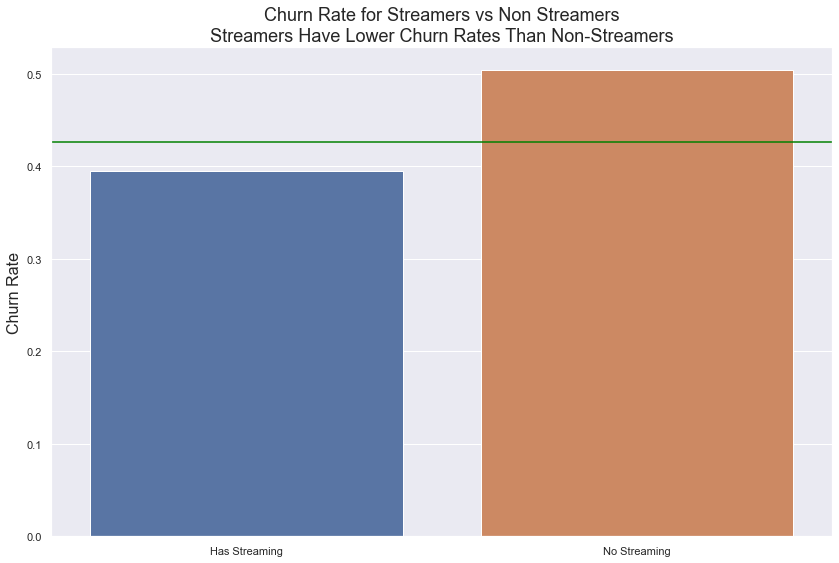

In [13]:
p = sns.barplot(x=['Has Streaming', 'No Streaming'], y = [(fiber.churn[fiber.has_streaming]).mean(),(fiber.churn[~fiber.has_streaming]).mean()])
p.axhline(fiber.churn.mean(), color = "green")
p.set_ylabel('Churn Rate', fontsize = 16)
p.set_title('Churn Rate for Streamers vs Non Streamers\nStreamers Have Lower Churn Rates Than Non-Streamers', fontsize = 18)

## Fiber customers are more satisfied with our streaming service than without it. Still, both streamers and non-streamers churn at rates much greater than the overall average.

## Predicting Churn

I evaluated four classification models to predict churn. I filtered the results so that only models with an accuracy drop-off from the train to validate set in the top quartile were considered to minimize risk of overfitting. I then ranked performance using the accuracy values obtained on the validate set.

#### My baseline is if we simply predicted everyone did not churn (given that the majority of individuals in the dataset do not). This would give us an accuracy of 73%.

In [14]:
baseline_accuracy = (train.churn == 0).mean()

In [15]:
# Selected features
selected_features = ['monthly_charges',
                     'is_autopay',
                     'has_internet_service',
                     'tenure',
                     'is_month_to_month',
                     'has_streaming',
                     'is_senior_citizen',
                     'is_paperless']
target = 'churn'

In [16]:
# Splitting the train, validate, and test sets 
X_train = train[selected_features]
y_train = train[[target]]

X_validate = validate[selected_features]
y_validate = validate[[target]]

X_test = test[selected_features]
y_test = test[[target]]

## Fitting Decision Tree and Random Forest Models

In [17]:
all_results = pd.DataFrame()
min_samples_range = range(1,10)
d_range = range(1,10)
# Iterates through both decision tree and random forest models. These models share the same hyperparameters
for model_name in ['decision_tree','random_forest']:
    depths =[]
    min_samples = []
    train_accuracies = []
    train_precisions = []
    train_recalls = []

    v_accuracies = []
    v_precisions = []
    v_recalls = []
    for d in d_range:
        for min_sample in min_samples_range:
            if model_name == 'decision_tree':
                clf, train_report = model.decision_tree_train(X_train, y_train, selected_features,target, d=d, m = min_sample , print_results=False)
            else:
                clf, train_report = model.random_forest_train(X_train, y_train, selected_features,target, d=d, m = min_sample , print_results=False)
                
            validate_report = model.classifier_validate(X_validate,y_validate, clf, print_results=False)

            depths.append(d)
            min_samples.append(min_sample)
            train_accuracies.append(train_report['accuracy'])
            train_precisions.append(train_report['precision'])
            train_recalls.append(train_report['recall'])

            v_accuracies.append(validate_report['accuracy'])
            v_precisions.append(validate_report['precision'])
            v_recalls.append(validate_report['recall'])
            
    train_results_df= pd.DataFrame(data = {"max_depth":depths,"min_samples_leaf":min_samples,"accuracy":train_accuracies,"precision":train_precisions,"recall":train_recalls})
    validate_results_df= pd.DataFrame(data = {"max_depth":depths,"min_samples_leaf":min_samples,"accuracy":v_accuracies,"precision":v_precisions,"recall":v_recalls})

    combined_df = train_results_df.merge(validate_results_df,on=['max_depth','min_samples_leaf'], suffixes=['_train','_validate'])
    combined_df["accuracy_diff"] = combined_df.accuracy_validate-combined_df.accuracy_train
    combined_df["precision_diff"] = combined_df.precision_validate-combined_df.precision_train
    combined_df["recall_diff"] = combined_df.recall_validate-combined_df.recall_train
    combined_df["accuracy_pct_diff"] = (combined_df.accuracy_validate-combined_df.accuracy_train)/combined_df.accuracy_train
    
    combined_df["model"] = model_name
    all_results = pd.concat([all_results,combined_df])

## K Nearest Neighbors

In [18]:
ks =[]
train_accuracies = []
train_precisions = []
train_recalls = []

v_accuracies = []
v_precisions = []
v_recalls = []

k_range = range(1,100)
for k in k_range:

    clf, train_report = model.knn_train(X_train, y_train,selected_features,target, k=k, print_results=False)
    validate_report = model.knn_validate(X_validate,y_validate, clf, print_results=False)

    ks.append(k)
    min_samples.append(min_sample)
    train_accuracies.append(train_report['accuracy'])
    train_precisions.append(train_report['precision'])
    train_recalls.append(train_report['recall'])

    v_accuracies.append(validate_report['accuracy'])
    v_precisions.append(validate_report['precision'])
    v_recalls.append(validate_report['recall'])

train_results_df= pd.DataFrame(data = {"k":ks,"accuracy":train_accuracies,"precision":train_precisions,"recall":train_recalls})
validate_results_df= pd.DataFrame(data = {"k":ks,"accuracy":v_accuracies,"precision":v_precisions,"recall":v_recalls})

combined_df = train_results_df.merge(validate_results_df,on=['k'], suffixes=['_train','_validate'])
combined_df["accuracy_diff"] = combined_df.accuracy_validate-combined_df.accuracy_train
combined_df["precision_diff"] = combined_df.precision_validate-combined_df.precision_train
combined_df["recall_diff"] = combined_df.recall_validate-combined_df.recall_train
combined_df["accuracy_pct_diff"] = (combined_df.accuracy_validate-combined_df.accuracy_train)/combined_df.accuracy_train

combined_df["model"] = "k_nearest_neighbors"
all_results = pd.concat([all_results,combined_df])

## Logistic Regression

In [19]:
cs =[]
train_accuracies = []
train_precisions = []
train_recalls = []

v_accuracies = []
v_precisions = []
v_recalls = []

c_range = np.linspace(0.01, 10000, num = 50)
for c in c_range:

    clf, train_report = model.logistic_regression_train(X_train, y_train,selected_features,target, c=c, print_results=False)
    validate_report = model.logistic_regression_validate(X_validate,y_validate, clf, print_results=False)

    cs.append(clf.C)
    min_samples.append(min_sample)
    train_accuracies.append(train_report['accuracy'])
    train_precisions.append(train_report['precision'])
    train_recalls.append(train_report['recall'])

    v_accuracies.append(validate_report['accuracy'])
    v_precisions.append(validate_report['precision'])
    v_recalls.append(validate_report['recall'])
    
train_results_df= pd.DataFrame(data = {"c":cs,"accuracy":train_accuracies,"precision":train_precisions,"recall":train_recalls})
validate_results_df= pd.DataFrame(data = {"c":cs,"accuracy":v_accuracies,"precision":v_precisions,"recall":v_recalls})

combined_df = train_results_df.merge(validate_results_df,on=['c'], suffixes=['_train','_validate'])
combined_df["accuracy_diff"] = combined_df.accuracy_validate-combined_df.accuracy_train
combined_df["precision_diff"] = combined_df.precision_validate-combined_df.precision_train
combined_df["recall_diff"] = combined_df.recall_validate-combined_df.recall_train
combined_df["accuracy_pct_diff"] = (combined_df.accuracy_validate-combined_df.accuracy_train)/combined_df.accuracy_train

combined_df["model"] = "logistic_regression"
all_results = pd.concat([all_results,combined_df])

In [20]:
# Identify the top quartile 
top_quarter = all_results.accuracy_pct_diff.quantile(0.75)
# Create a dataframe of only those results in the top quartile by pct accuracy difference
filtered = all_results[all_results.accuracy_pct_diff>top_quarter]

In [21]:
# Show top 3 models
filtered.sort_values(by="accuracy_validate", ascending=False).head(3)

,max_depth,min_samples_leaf,accuracy_train,precision_train,recall_train,accuracy_validate,precision_validate,recall_validate,accuracy_diff,precision_diff,recall_diff,accuracy_pct_diff,model,k,c
86,NaN,NaN,0.795784,0.672365,0.451243,0.786137,0.635802,0.458797,-0.009646,-0.036562,0.007554,-0.012122,k_nearest_neighbors,87.0,NaN
83,NaN,NaN,0.795276,0.675439,0.441683,0.785545,0.638095,0.447661,-0.009731,-0.037343,0.005979,-0.012235,k_nearest_neighbors,84.0,NaN
82,NaN,NaN,0.796038,0.673324,0.451243,0.784953,0.633540,0.454343,-0.011085,-0.039783,0.003100,-0.013925,k_nearest_neighbors,83.0,NaN


## Top 3 models all use the K Nearest Neighbors algorithm and have k values: of 87 (top), 84 and 83. 
### Validate accuracy is 0.786
### Precision is 0.635
### Recall is 0.459

### This model will be tested on the test set

In [68]:
clf, train_report = model.knn_train(X_train, y_train, selected_features, target, k=87, print_results=True)
test_report = model.knn_validate(X_test, y_test, clf)

TRAINING RESULTS: KNeighborsClassifier
Using features: ['monthly_charges', 'is_autopay', 'has_internet_service', 'tenure', 'is_month_to_month', 'has_streaming', 'is_senior_citizen', 'is_paperless']
K of 87
----------------
              precision    recall  f1-score   support

           0       0.82      0.92      0.87      2891
           1       0.67      0.45      0.54      1046

    accuracy                           0.80      3937
   macro avg       0.75      0.69      0.70      3937
weighted avg       0.78      0.80      0.78      3937

False positive rate: 7.96%
False negative rate: 54.88%
True positive rate: 45.12%
True negative rate: 92.04%
----------------
-----VALIDATE/TEST RESULTS: KNeighborsClassifier-----
Using features: ['monthly_charges', 'is_autopay', 'has_internet_service', 'tenure', 'is_month_to_month', 'has_streaming', 'is_senior_citizen', 'is_paperless']
K of 87
              precision    recall  f1-score   support

           0       0.83      0.91      0.87     

In [86]:
# Create dataframe of the test report
test_report = pd.DataFrame(data = [test_report])
# Append '_test' to each column in test
test_report.columns = [c+'_test' for c in test_report]
# Get row for selected k value
final_result = all_results[all_results.k == 87]
# Merge train, validate, and test results into one dataframe
final_result = pd.merge(final_result, test_report,left_on='k',right_on='k_test')

Text(0.5, 1.0, 'Accuracy comparison')

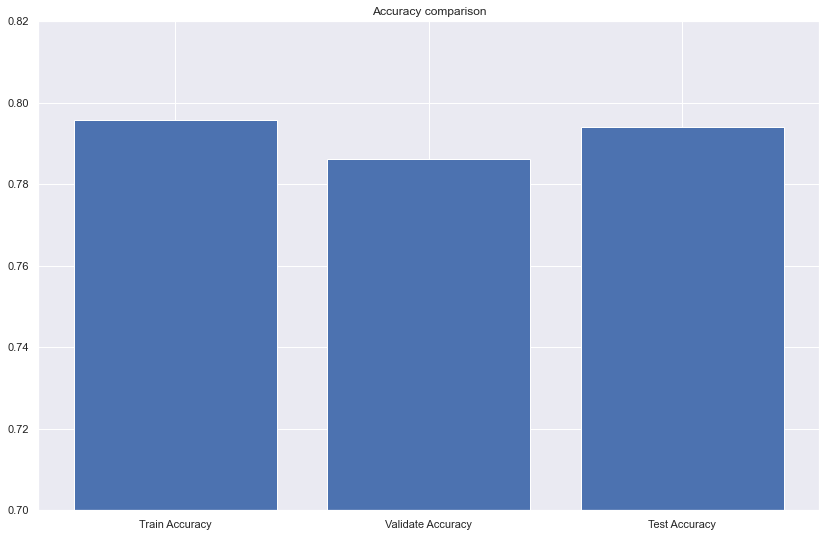

In [97]:
# Compare accuracy from different data sets
plt.bar(x=['Train Accuracy',
           'Validate Accuracy',
           'Test Accuracy'],
        height = [final_result.accuracy_train[0], final_result.accuracy_validate[0], final_result.accuracy_test[0]])
plt.ylim(0.7,0.82)
plt.title('Accuracy comparison')